Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514 / EEL7513 / EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$
$\newcommand{\bT}{\mathbf{T}}$


# Exercício 9: Clustering e Detecção de Anomalias

Neste exercício, você irá explorar dois problemas de aprendizado de máquina: clustering usando o algoritmo K-means e detecção de anomalias usando um modelo gaussiano.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import wget
from scipy.io import loadmat

from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

def plot_data_cluster(X, labels=None, centroids=None, previous_centroids=None, voronoi=False):
    from scipy.spatial import Voronoi, voronoi_plot_2d
    if voronoi and centroids is not None:
        voronoi_plot_2d(Voronoi(centroids), show_points=False, show_vertices=False);
    if labels is None:
        plt.scatter(X[:,0], X[:,1], s=50)
    else:
        plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.brg, s=50)
    if centroids is not None:
        if previous_centroids is not None:
            plt.scatter(previous_centroids[:,0], previous_centroids[:,1], c=range(centroids.shape[0]), 
                        cmap=plt.cm.brg, marker='X', s=200, linewidths=2, edgecolors='gray')
            for k in range(centroids.shape[0]):
                M = np.r_[previous_centroids[[k]], centroids[[k]]]
                plt.plot(M[:,0],M[:,1],'k-')
        plt.scatter(centroids[:,0], centroids[:,1], c=range(centroids.shape[0]), 
                    cmap=plt.cm.brg, marker='X', s=200, linewidths=2, edgecolors='k')
    gap = (X.max(axis=0) - X.min(axis=0))*0.05
    plt.axis(np.r_[X.min(axis=0)-gap, X.max(axis=0)+gap][[0,2,1,3]])
    plt.show()

def plot_data_anomaly(X, outliers=None, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    plt.gcf().set_size_inches(5, 5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (Mbit/s)');
    # circle outliers
    if outliers is not None:
        outliers = outliers > 0
        plt.scatter(X[outliers,0], X[outliers,1], c='none', marker='o', 
                    edgecolors='red', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 11), cmap=plt.cm.Greens_r, zorder=-1)
    plt.show()

# Clustering com K-Means

## 1. Conjunto de dados #1

Inicialmente, nosso objetivo é entender o funcionamento do algoritmo e como utilizar a função `sklearn.cluster.KMeans`. Para isso, utilizaremos um conjunto de dados sintético bem simples, o qual pode ser visualizado pelos comandos abaixo.

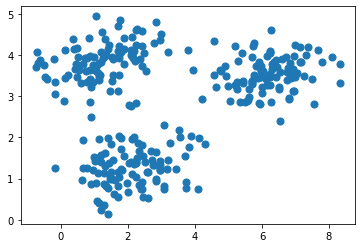

In [152]:
plot_data = plot_data_cluster
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=300, n_features=2, centers=[[1, 1], [3, 3], [0.5, 3.8]], cluster_std=0.45, random_state=0)
X = X @ [[2, 0.2], [0.1, 1]]
plot_data(X)

1. Rode o algoritmo K-means com K=3 clusters partindo dos centróides iniciais dados abaixo e plote o resultado obtido (i.e., atribuição de clusters e respectivos centróides). Quantas iterações foram necessárias para convergência? Mostre também o valor final da função custo (soma dos quadrados de todas as distâncias aos respectivos centróides), chamado no `sklearn` de `inertia`.

#### Dicas
- Utilize a função `plot_data(X, labels, centroids)`

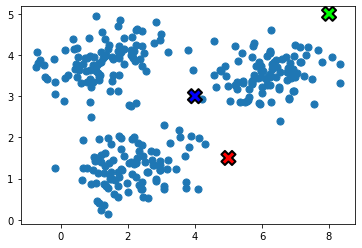

In [153]:
initial_centroids = np.array([[4, 3], [5, 1.5], [8, 5]])
plot_data(X, None, initial_centroids)

Iterações:  8
Loss:  308.90784596613565


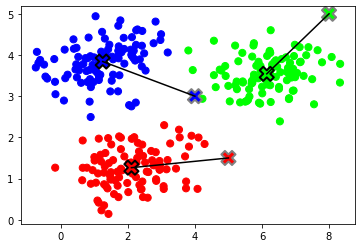

In [86]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, init=initial_centroids,n_init=1, max_iter=300)
model.fit(X)

# plot_data(X, labels, centroids, previous_centroids)
print("Iterações: ", model.n_iter_)
print("Loss: ", model.inertia_)
plot_data(X, model.labels_, model.cluster_centers_, previous_centroids=initial_centroids)

2. Repita o item anterior mostrando as atribuições de clusters, os centróides e o custo obtidos **a cada meia iteração** do algoritmo. Para isso, complete as funções abaixo com sua implementação própria do K-means. (Isso é necessário pois o `sklearn` não fornece os resultados obtidos a cada iteração.) Confirme que o resultado após a última iteração é condizente com o resultado do item anterior.

#### Dicas
- Note que, na implementação abaixo (diferentemente do que está nos slides), a primeira parte da iteração corresponde ao cálculo dos centróides (a partir dos rótulos) e a segunda parte da iteração corresponde ao cálculo dos rótulos (a partir dos centróides).
- Opcionalmente, ao invés de implementar as funções `update_centroids` e `update_labels`, você pode diretamente alterar a função `k_means` para utilizar a função `sklearn.cluster.KMeans` com `max_iter=1` e `init` adequado. No entanto, a implementação do `sklearn` é um pouco diferente: segue a ordem dos slides (atualização de rótulos, atualização de centróides), porém contém um passo adicional de atualização de rótulos caso as iterações terminem antes da convergência. Portanto, seguindo essa abordagem, não será possível obter os rótulos da primeira iteração, apenas da segunda em diante. (Mas, tudo bem, essa solução também será aceita.)

In [146]:
K = centroids.shape[0] # = initial_centroids.shape[0] = 3
n_features = X.shape[1] # = 2
centroids_ = np.empty((K, n_features)) # shape = (3,2)
centroids_[0]

array([0., 0.])

**CENTROID:**
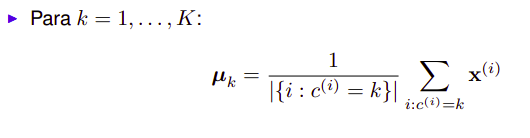

**LABELS**
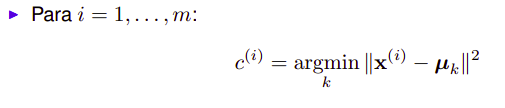

In [148]:
# own implementation
def update_centroids(X, labels, K):
    
    K = centroids.shape[0] # = initial_centroids.shape[0] = 3
    n_features = X.shape[1] # = 2
    centroids_ = np.empty((K, n_features)) # shape = (3,2)
    
    # percorre os 3 centroids
    for c in range(K):
        centroids[c] = np.sum(X) / labels[c]
    return centroids

def update_labels(X, centroids):
    K = centroids.shape[0]
    labels = np.zeros(len(X))
    
    for c in range(K):
        euclidian = np.linalg.norm(X - centroids[c])
        labels_idx = np.argmin(euclidian)  
    return labels

def compute_inertia(X, centroids, labels):
    if labels is None:
        return np.nan
    inertia = np.linalg.norm(X - centroids)
    return inertia

def k_means(X, initial_centroids, max_iter=300):
    centroids = initial_centroids
    labels = None
    history = []
    K = centroids.shape[0]
    for i in range(max_iter):
        if i > 0:
            centroids = update_centroids(X, labels, K)
        previous_labels = labels
        labels = update_labels(X, centroids)
        history.append((centroids, labels))
        if np.all(labels == previous_labels):
            break
    return centroids, labels, history

In [149]:
centroids, labels, result = k_means(X, initial_centroids)
result = [(None, None)] + result

from ipywidgets import interact
@interact(i=(0,len(result)-1, 0.5))
def _(i=8):
    first_half = (i % 1 == 0.5)
    i = int(i)
    if first_half:
        previous_centroids, labels = result[i]
        centroids, _ = result[i+1]
        plot_data(X, labels, centroids, previous_centroids)
    else:
        centroids, labels = result[i]
        plot_data(X, labels, centroids, voronoi=True)
    inertia = compute_inertia(X, centroids, labels)
    print('Inertia: {:g}'.format(inertia))

<ipython-input-148-5e1292415f5b>:10: RuntimeWarning: divide by zero encountered in double_scalars
  centroids[c] = np.sum(X) / labels[c]


interactive(children=(FloatSlider(value=2.0, description='i', max=2.0, step=0.5), Output()), _dom_classes=('wi…

Daqui para frente, pode ignorar sua implementação e considerar apenas a do `sklearn`.

3. Rode novamente o algoritmo do `sklearn`, mas agora com todas as configurações padrão (o que, em particular, envolve múltiplas reinicializações aleatórias com métodos sofisticados de inicialização), e verifique se o algoritmo convergiu para uma solução semelhante.

Iterações:  8
Loss:  112.10698516489832


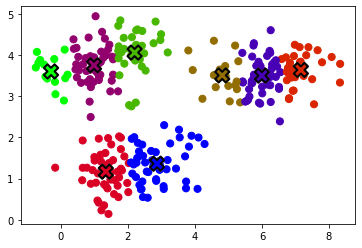

In [162]:
from sklearn.cluster import KMeans

model = KMeans()
model.fit(X)

# plot_data(X, labels, centroids, previous_centroids)
print("Iterações: ", model.n_iter_)
print("Loss: ", model.inertia_)
plot_data(X, model.labels_, model.cluster_centers_, previous_centroids= model.cluster_centers_)

In [159]:
model.cluster_centers_

array([[ 2.86983661,  1.36099394],
       [ 6.0318515 ,  3.49375147],
       [ 2.20044616,  4.0582755 ],
       [ 0.98986796,  3.74965661],
       [ 1.34128964,  1.16733448],
       [ 7.15962044,  3.63620974],
       [-0.2927974 ,  3.60050722],
       [ 4.90042809,  3.51536125]])

## 2. Conjunto de dados #2

O próximo conjunto de dados é formado pelas cores dos pixels (no espaço RGB) da imagem abaixo:

(128, 128, 3)
(16384, 3)


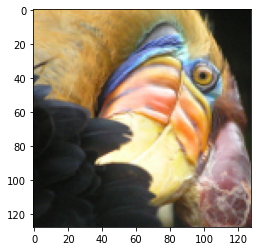

In [461]:
filename = 'bird_small.png'
if not os.path.exists(filename):
    wget.download('https://github.com/danilo-silva-ufsc/ml/raw/master/data/' + filename)
image = plt.imread(filename)
print(image.shape)
plt.imshow(image)
X = image.reshape(-1, 3)
print(X.shape)

1. Rode o K-means para agrupar as cores dos pixels da imagem em K=16 clusters. Em seguida, substitua a cor de cada pixel da imagem pelo centróide do cluster correspondente e mostre as duas imagens lado a lado. 
1. Repita para vários valores de K e observe as diferenças.
1. (OPCIONAL) Experimente também com outras imagens à sua escolha.

#### Dica
- Para reduzir o tempo de treinamento, experimente reduzir o número de inicializações aleatórias (`n_init`).

Iterações:  21
Inertia:  117.71343994140625

Labels: (16384,)
Centroids: (16, 3)
Shape image: (128, 128, 3)

Imagem de 16 bits
Shape image_rec: (128, 128, 3)


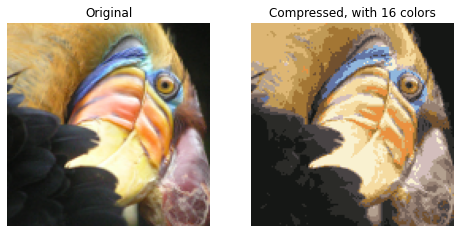

In [462]:
from sklearn.cluster import KMeans

K = 16
model = KMeans(n_clusters=K)
model.fit(X)

# plot_data(X, labels, centroids, previous_centroids)
print("Iterações: ", model.n_iter_)
print("Inertia: ", model.inertia_)

# ================== RESHAPE ================== #

# substitua a cor de cada pixel da imagem pelo centróide do cluster correspondente mostre 
# as duas imagens lado a lado.
centroids = model.cluster_centers_
label = model.labels_
print(f'\nLabels: {label.shape}')
print(f'Centroids: {centroids.shape}')

image_rec = centroids[label].reshape(image.shape) 
print(f'Shape image: {image.shape}')
print(f'\nImagem de {centroids.shape[0]} bits')
print(f'Shape image_rec: {image_rec.shape}')


plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Original')
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(image_rec)
plt.title('Compressed, with {} colors'.format(K))
plt.axis('off');

In [463]:
@interact(K = (0,64,2))
def _(K):
    model = KMeans(n_clusters=K)
    model.fit(X)

    centroids = model.cluster_centers_
    label = model.labels_

    image_rec = centroids[label].reshape(image.shape) 
    print(f'\nImagem de {centroids.shape[0]} bits')
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off');
    plt.subplot(1,2,2)
    plt.imshow(image_rec)
    plt.title('Compressed, with {} colors'.format(K))
    plt.axis('off');
    plt.show()

interactive(children=(IntSlider(value=32, description='K', max=64, step=2), Output()), _dom_classes=('widget-i…

In [464]:
@interact(K = (0,16,2), init = ['random','k-means++'], algorithm = ['auto', 'full', 'elkan'])
def _(K, init, algorithm):
    model = KMeans(n_clusters=K, init=init, algorithm=algorithm)
    model.fit(X)

    centroids = model.cluster_centers_
    label = model.labels_

    image_rec = centroids[label].reshape(image.shape) 
    print(f'\nImagem de {centroids.shape[0]} bits')
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off');
    plt.subplot(1,2,2)
    plt.imshow(image_rec)
    plt.title('Compressed, with {} colors'.format(K))
    plt.axis('off');
    plt.show()

interactive(children=(IntSlider(value=8, description='K', max=16, step=2), Dropdown(description='init', option…

(135, 373, 3)
(50355, 3)


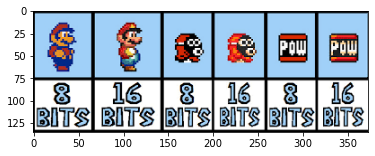

In [468]:
filename = 'mario.png'
image = plt.imread(filename)
print(image.shape)
plt.imshow(image)
XX = image.reshape(-1, 3)
print(XX.shape)

(560, 900, 3)
(504000, 3)


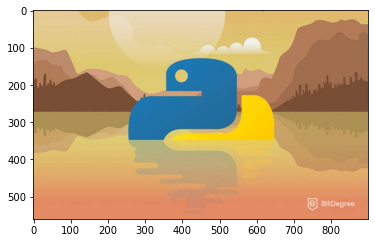

In [485]:
filename = 'python.jpg'
image2 = plt.imread(filename)
print(image.shape)
plt.imshow(image)
XXX = image.reshape(-1, 3)
print(XXX.shape)

In [475]:
@interact(K = (0,16,2))
def _(K):
    model = KMeans(n_clusters=K)
    model.fit(XX)

    centroids = model.cluster_centers_
    label = model.labels_

    image_rec = centroids[label].reshape(image.shape) 
    print(f'\nImagem de {centroids.shape[0]} bits')

    plt.figure(figsize=(15, 12))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off');
    plt.subplot(1,2,2)
    plt.imshow(image_rec)
    plt.title('Compressed, with {} colors'.format(K))
    plt.axis('off');
    plt.tight_layout()

interactive(children=(IntSlider(value=8, description='K', max=16, step=2), Output()), _dom_classes=('widget-in…

In [484]:
@interact(K = (0,16,2))
def _(K):
    model = KMeans(n_clusters=K)
    model.fit(XXX)

    centroids = model.cluster_centers_
    label = model.labels_

    image_rec = centroids[label].reshape(image.shape) 
    print(f'\nImagem de {centroids.shape[0]} bits')

    plt.figure(figsize=(15, 12))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off');
    plt.subplot(1,2,2)
    plt.imshow(image_rec)
    plt.title('Compressed, with {} colors'.format(K))
    plt.axis('off');
    plt.tight_layout()

interactive(children=(IntSlider(value=8, description='K', max=16, step=2), Output()), _dom_classes=('widget-in…

# Conjunto de dados #3

O próximo conjunto de dados é o MNIST e o objetivo é avaliar o desempenho do K-means para encontrar grupos de dígitos similares. Nesse caso, o espaço de atributos será formado pelos 784 pixels da imagem, um problema de dimensionalidade elevada. Para reduzir a complexidade, usaremos apenas um subconjunto das amostras.

In [237]:
from sklearn.datasets import fetch_openml
X_full, y_full = fetch_openml('mnist_784', return_X_y=True)
y_full = y_full.astype('int8')
print(X_full.shape, y_full.shape)

(70000, 784) (70000,)


In [238]:
m = 3000
subset = np.random.RandomState(seed=0).permutation(X_full.shape[0])[:m]
X = X_full[subset]
y = y_full[subset]
print(X.shape, y.shape)

(3000, 784) (3000,)


Como os rótulos são conhecidos, é possível medir a acurácia do agrupamento tratando-o como um problema de classificação---a menos de uma permutação, pois o algoritmo de clustering não tem como adivinhar exatamente quais são os rótulos. Para fazer uma avaliação justa, você pode dar a um cluster o rótulo correspondente ao dígito que aparece com maior frequência no cluster. Além disso, você deve utilizar K=10.

1. Aplique o K-means no conjunto de dígitos MNIST e analise os clusters encontrados. Para isso:
 1. Calcule a [matriz de contingência](https://scikit-learn.org/stable/modules/clustering.html#contingency-matrix) (`sklearn.metrics.cluster.contingency_matrix`), cujo elemento $(j,k)$ indica o número de amostras de rótulo $j$ que foram alocadas ao cluster $k$.
 1. Determine o melhor mapeamento entre clusters e rótulos, i.e., um array `best_map` cujo elemento $k$ contém o índice do valor máximo coluna $k$. Note que pode haver valores repetidos.
 1. Considerando este mapeamento, determine a acurácia do agrupamento obtido.
 1. Visualize os centróides de cada cluster. Indique no título de cada imagem o dígito predito para este cluster (i.e., o rótulo mais frequente) e sua frequência de ocorrência dentro do cluster.
2. (OPCIONAL) Experimente usar o DBSCAN e tente explicar por que ele **não** funciona para este problema. Certifique-se de variar o parâmetro `eps` de forma a obter dois tipos de soluções: nenhum cluster (só ruído) ou um único cluster contendo todos os pontos.

In [288]:
K = 10
model = KMeans(n_clusters=K)
model.fit(X)

centroids = model.cluster_centers_
label = model.labels_

print(f"Labels:{label}\n")
print(f"Centroids:\n{centroids}")

Labels:[5 8 4 ... 4 4 6]

Centroids:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Calcule a [matriz de contingência](https://scikit-learn.org/stable/modules/clustering.html#contingency-matrix) (`sklearn.metrics.cluster.contingency_matrix`), cujo elemento $(j,k)$ indica o número de amostras de rótulo $j$ que foram alocadas ao cluster $k$.

In [289]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix = contingency_matrix(y, model.predict(X))
print(f'Matriz de Contingência:\n{contingency_matrix}')

Matriz de Contingência:
[[ 89   0   0  19   0 188   0  11   2   1]
 [  0   0   1   0 206   0 135   0   0   0]
 [ 13   0 218   8  12   1  17   8  10  10]
 [ 22   4   8 183  16   0   5   2  16  27]
 [  4 103   0   0   7   0  10   9 164   0]
 [ 52   8   0  98   9   1  31   1  16  28]
 [ 55   0   5   2  12   3   2 208   3   0]
 [  0 186   2   0  17   1  13   0 106   2]
 [  3  10   3  46  15   0  23   2  13 196]
 [  1 113   1   4   8   1   5   1 165   0]]


#### Determine o melhor mapeamento entre clusters e rótulos, i.e., um array best_map cujo elemento  𝑘  contém o índice do valor máximo coluna  𝑘 . Note que pode haver valores repetidos.

In [308]:
# amax = Return the maximum of an array or maximum along an axis.
# Axis = 0: maxima along the first axis
best_map = np.amax(contingency_matrix, axis = 0) #valor máximo coluna k
best_map

array([ 89, 186, 218, 183, 206, 188, 135, 208, 165, 196])

In [290]:
print(f'Accuracy: {(round(np.sum(best_map)/ np.sum(contingency_matrix),2))*100} %')

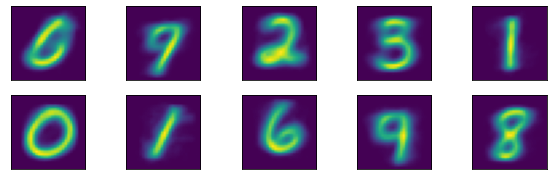

In [311]:
fig,ax = plt.subplots(2,5,figsize=(10,3))
centers = centroids.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center)

# Detecção de anomalias

## 4. Conjunto de dados #4

Neste parte do exercício, o objetivo é construir um modelo gaussiano para detecção de anomalias. Inicialmente, usaremos um conjunto de dados que (supostamente) possui como atributos o _throughput_ (Mbit/s) e a latência (ms) da resposta de cada servidor de uma rede, medidos em vários momentos durante seu funcionamento. O objetivo é detectar quando o servidor está se comportando de forma anômala. Você dispõe de um conjunto de treinamento não-rotulado `X` e um conjunto de validação rotulado `(X_val, y_val)`, onde o rótulo 1 indica uma anomalia e o rótulo 0 indica um amostra normal.

Note que o conjunto de treinamento não é garantidamente livre de amostras anômalas, i.e., provavelmente é um conjunto "contaminado". Dessa forma, o problema se enquadrada como aprendizado não-supervisionado. O conjunto de validação será usado exclusivamente para avaliação do modelo e seleção de hiperparâmetros, portanto não iremos dispor de quaisquer rótulos no treinamento.

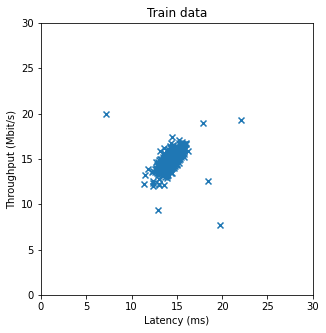

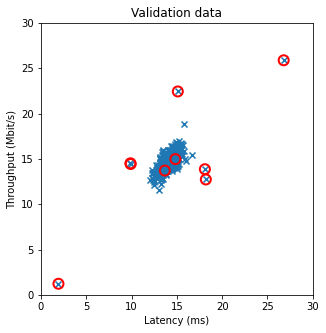

Train shape: (307, 2)
 Val shapes: (307, 2) (307,)


In [312]:
plot_data = plot_data_anomaly
filename = 'anomaly1.mat'
if not os.path.exists(filename):
    wget.download('https://github.com/danilo-silva-ufsc/ml/raw/master/data/' + filename)
data = loadmat(filename)
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
plt.title('Train data')
plot_data(X)
plt.title('Validation data')
plot_data(X_val, y_val)
print('Train shape:', X.shape)
print(' Val shapes:', X_val.shape, y_val.shape)

1. Utilize um modelo gaussiano multivariável para ajustar o conjunto de treinamento, i.e., estime a média e a matriz de covariância dos dados. Para isso, utilize as funções `np.mean()` e `np.cov()` (configure corretamente a orientação dos eixos e demais parâmetros). Trace curvas de nível da densidade de probabilidade usando a função `plot_data(X, None, mean, cov)`. 
2. Para fins de comparação, realize também uma estimação da matriz de covariância sob a hipótese de independência, i.e., estime a variância de cada dimensão independentemente e utilize esses valores para produzir uma matriz de covariância diagonal. Para isso, utilize a função `np.var()`. Também visualize as curvas de nível.
3. Qual estimação parece mais adequada? Por quê?

In [320]:
mean = np.mean(X,axis=0)
cov = np.cov(X,rowvar=False)
print(f'Média: {mean}\n')
print(f'Covariância:\n{cov}')

Média: [14.22064407 14.79786881]

Covariância:
[[1.26174916 0.48988887]
 [0.48988887 1.48598517]]


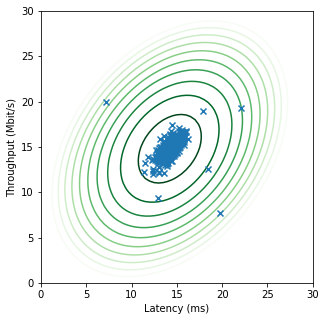

In [321]:
plot_data(X,None,mean,cov)

In [335]:
# Estimando a variância de cada dimensão, independente:
dim1 = np.var(X[:,0])
dim2 = np.var(X[:,1])
ar = np.array([dim1,dim2])
print('Variância 1:',dim1)
print('Variância 2:',dim2)
print('Array:     ',ar)

Variância 1: 1.257639225801333
Variância 2: 1.4811448291162668
Array:      [1.25763923 1.48114483]


In [337]:
# Utilize esses valores para produzir uma matriz de covariância diagonal
ar_diag = np.diag(ar)
ar_diag

array([[1.25763923, 0.        ],
       [0.        , 1.48114483]])

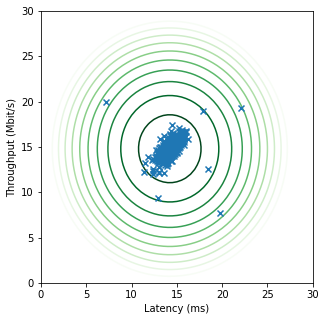

In [338]:
plot_data(X,None,mean,ar_diag)

Para realizar a detecção de anomalias, é necessário definir um limiar $\epsilon$ de tal forma que uma amostra $\bx$ é classificada como anômala quando $p(\bx) < \epsilon$. Não há um valor correto ou uma forma única de escolher este limiar; em última análise, trata-se de uma escolha arbitrária e que depende do modelo. Caso esteja disponível um conjunto de validação, uma forma objetiva de escolher o limiar é escolher aquele que maximiza uma métrica de classificação sobre o conjunto de validação. Naturalmente, a métrica deve ser robusta ao desbalanceamento do conjunto.

4. Escolha alguns valores de $\epsilon$ e realize a predição no conjunto de **treinamento**. Para isso, utilize a função `scipy.stats.multivariate_normal(mean, cov)` para definir o modelo e o respectivo método `.pdf()` para calcular a densidade de probabilidade. Marque as anomalias encontradas no gráfico usando a função `plot_data(X, y_pred, mean, cov)`.

5. Em seguida, implemente uma função `select_threshold(p, y)` que tem como entrada um vetor `p` de probabilidades das amostras (estimadas segundo o modelo ajustado) e um vetor `y` com seus respectivos rótulos, e que retorna o valor de $\epsilon$ que maximiza o score F1 no conjunto fornecido, bem como o valor de F1 obtido.

6. Utilize essa função no conjunto de **validação** para determinar $\epsilon$ e F1. Com este valor de limiar, realize a predição no conjunto de **treinamento** e novamente marque as anomalias no gráfico.

#### Dicas

- Você pode utilizar a função `sklearn.metrics.f1_score` para calcular o score F1.

In [364]:
from sklearn.metrics import f1_score

In [359]:
import scipy

mean = np.mean(X,axis=0)
cov = np.cov(X,rowvar=False)
p = scipy.stats.multivariate_normal(mean, cov).pdf(X)


@interact(ep = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,0.1,0.2,1])
def _(ep):
    y_pred = p < ep
    plot_data(X,y_pred,mean,cov)

interactive(children=(Dropdown(description='ep', options=(0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, …

In [367]:
def select_threshold(p, y):
    bestEpsilon = 0
    bestF1 = 0
    
    ep = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,0.1,0.2]
    
    for c in ep:
        y_pred = p < c
        F1 = f1_score(y, y_pred)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = c
            #print('Best F1',bestF1)
            #print('Best Epsilon', bestEpsilon)
    return bestEpsilon,bestF1

In [368]:
p = multivariate_normal(mean, cov).pdf(X)

p_val = multivariate_normal(mean, cov).pdf(X_val)

epsilon, F1 = select_threshold(p_val, y_val)

y_pred = p < epsilon

print('epsilon =', epsilon)
print('F1 =', F1)

epsilon = 0.0001
F1 = 0.8750000000000001


7. Agora, realize a detecção de anomalias utilizando a função `sklearn.covariance.EllipticEnvelope` e compare os resultados obtidos. Esta função assume o mesmo modelo probabilístico, porém com duas diferenças:
 - A estimação de variância é robusta a outliers;
 - A predição é feita usando um valor de $\epsilon$ calculado automaticamente de tal forma a obter uma determinada fração de outliers, dada pelo parâmetro `contamination`.

8. Varie o parâmetro `contamination` e observe sua influência. Em cada caso, determine um intervalo onde o $\epsilon$ efetivo se encontraria, isto é, a máxima probabilidade de uma amostra considerada anômala pelo modelo e a mínima probabilidade de uma amostra considerada normal. Como o modelo não fornece probabilidades, será necessário utilizar novamente a função `multivariate_normal` apenas para esse cálculo.


#### Dicas
- A função `EllipticEnvelope` utiliza a codificação -1 para representar uma amostra anômala e 1 para uma amostra normal, então será necessário convertê-los para utilizar a função `plot_data`.
- Os parâmetros estimados pelo modelo (para uso pela função `plot_data` e `multivariate_normal`) ficam armazenados em `.location_` e `.covariance_`.

In [460]:
from sklearn.covariance import EllipticEnvelope
@interact(c = (0,20,1))
def _(c):

    model = EllipticEnvelope(contamination=c*1e-3)
    model.fit(X)
    mean = model.location_
    cov = model.covariance_
    
    y_pred = model.predict(X)
    #print(y_pred)
    
    # o rótulo 1 indica uma anomalia e o rótulo 0 indica um amostra normal
    y_h = []
    for values in y_pred:
        if values == -1:
            y_pred = 1 # anômala
            y_h.append(y_pred)
        else:
            y_pred = 0 # normal
            y_h.append(y_pred)
    arr = np.array([y_h])
    arr = arr.reshape(-1)
    plot_data(X, arr, mean, cov)

interactive(children=(IntSlider(value=10, description='c', max=20), Output()), _dom_classes=('widget-interact'…

## 5. Conjunto de dados #5

O próximo conjunto de dados possui $n=11$ atributos e um maior número de amostras de treinamento. Para uma maior variabilidade, também é feita uma transformação linear aleatória do espaço (correspondendo a rotações, reflexões e escalonamentos) através de uma matriz $\bT$.

In [16]:
filename = 'anomaly2.mat'
if not os.path.exists(filename):
    wget.download('https://github.com/danilo-silva-ufsc/ml/raw/master/data/' + filename)
data = loadmat(filename)
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]

# A bit of randomness
seed = 0
n = X.shape[1]
T = np.random.RandomState(seed).randn(n,n)
X = X @ T
X_val = X_val @ T
print(X.shape, X_val.shape)

(1000, 11) (100, 11)


1. Repita os itens anteriores comparando os 3 tipos de modelo gaussiano abordados: estimação de covariância completa, estimação de covariância diagonal e modelo `EllipticEnvelope` do sklearn. Desta vez não será possível visualizar a densidade de probabilidade em um espaço 11-dimensional, mas o score F1 no conjunto de validação pode ser calculado. Determine também o número de anomalias encontradas (no conjunto de treinamento) em cada modelo. Mais precisamente, para cada modelo:
 1. Ajuste o modelo, escolhendo adequadamente seus respectivos hiperparâmetros.
 1. Realize a predição no conjunto de treinamento.
 1. Calcule a fração de anomalias no conjunto de treinamento e compare-a com a de validação.
 1. Determine o valor de $\epsilon$ ou um intervalo onde o $\epsilon$ efetivo se encontraria.
1. Na comparação com o método de estimação da covariância diagonal, experimente utilizar vários estados diferentes (`seed`) do gerador de números aleatórios. O que você observa? Explique.


## 6. (OPCIONAL)

1. (OPCIONAL) Aplique o método de clustering DBSCAN para detecção de anomalias nos dois conjuntos fornecidos e analise os resultados observados.